In [2]:
#@title Imports
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras import *
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import BinaryCrossentropy
from keras.optimizers import adam_v2
from keras.utils.vis_utils import plot_model

from keras_tuner import * 

In [5]:
# load dataframe, delete article link column
pd.set_option('display.max_colwidth', None)
# there are v1 and v2
file_name = 'Sarcasm_Headlines_Dataset.json'
df = pd.read_json(file_name, lines=True)
del df['article_link']
df.head(5)

,headline,is_sarcastic
0,former versace store clerk sues over secret 'black code' for minority shoppers,0
1,"the 'roseanne' revival catches up to our thorny political mood, for better and worse",0
2,mom starting to fear son's web series closest thing she will have to grandchild,1
3,"boehner just wants wife to listen, not come up with alternative debt-reduction ideas",1
4,j.k. rowling wishes snape happy birthday in the most magical way,0


# Preprocessing

In [6]:
appos = {
        "aren't": "are not", "can't": "cannot", "couldn't": "could not", "didn't": "did not", "doesn't": "does not", "don't": "do not",
        "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he had", "he'll": "he will", "he's": "he is",
        "I'd": "I had", "I'll": "I will", "I'm": "I am", "I've": "I have", "isn't": "is not", "let's": "let us", "mightn't": "might not",
        "mustn't": "must not", "shan't": "shall not", "she'd": "she had", "she'll": "she will", "she's": "she is", "shouldn't": "should not",
        "what's": "what is", "there's": "there is", "they'd": "they had", "they'll": "they will", "they've": "they have",
        "we'd": "we had", "we're": "we are", "we've": "we have", "weren't": "were not",
}
def transform_appos(headline):
    arr = []
    for row in headline.values:
        for word in row:
            if word in appos.keys():
                row = row.replace(word, appos[word])
    return headline

def to_lowercase(headline):
    headline = headline.apply(lambda x: x.lower())
    return headline

def remove_whitespaces(headline):
    headline = headline.str.strip()
    return headline

def replace_quote(headline):
    headline = headline.str.replace("’", "'")
    return headline

def preprocess(headlines: pd.Series):
    headlines = to_lowercase(headlines)
    headlines = replace_quote(headlines)
    headlines = transform_appos(headlines)
    return headlines

# apply preprocessing to the whole dataset
df['headline'] = preprocess(df['headline'])

In [35]:
# split data into train and test set into 60:20:20
train_df, test_df = train_test_split(df, train_size=0.6, shuffle=True, random_state=0)
val_df, test_df = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=0)

# separate data from labels
x_train, y_train = train_df['headline'], train_df['is_sarcastic']
x_test, y_test = test_df['headline'], test_df['is_sarcastic']
x_val, y_val = val_df['headline'], val_df['is_sarcastic']

In [36]:
# tokenization, padding, truncation
vocab_size = 10000
oov_token = '<OOV>'
MAXLEN = 128
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(x_train)
train_padded = pad_sequences(train_sequences, padding='post', truncating='post', maxlen=MAXLEN)

test_sequences = tokenizer.texts_to_sequences(x_test)
test_padded = pad_sequences(test_sequences, padding='post', truncating='post', maxlen=MAXLEN)

val_sequences = tokenizer.texts_to_sequences(x_val)
val_padded = pad_sequences(val_sequences, padding='post', truncating='post', maxlen=MAXLEN)

# Need this block to get it to work with TensorFlow 2.x
x_train = np.array(train_padded)
x_test = np.array(test_padded)
x_val = np.array(val_padded)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

# Create and train model

In [37]:
# Callbacks
stop_early = EarlyStopping(monitor='val_loss', patience=3)
save_best_model = ModelCheckpoint('checkpoints/rnn', 
                                    monitor='val_loss',
                                    save_best_only=True,
                                    save_weights_only=False)

In [102]:
# create hypermodel
def model_builder(hp: HyperParameters = None) -> Model:
    # inputs
    inputs = Input(shape=(MAXLEN,), dtype=tf.int32, name='input')

    # embedding layer
    embedding_dim = hp.Int('embedding_dim', min_value=100, max_value=800 , step=50)
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=MAXLEN,
                                name='embedding')

    pool_layer = MaxPool1D()

    # first lstm layer
    lstm_units = hp.Int('units1', min_value=16, max_value=512, step=32)
    lstm_dropout=hp.Choice('lstm1_dropout', values=[0.0, 0.1, 0.2])
    lstm = Bidirectional(LSTM(units=lstm_units, 
                       dropout=lstm_dropout,
                       # need return_sequences when chaining multiple bidirectional lstms
                       return_sequences=True),
                       name='lstm')

    # second lstm layer
    lstm2_units = hp.Int('units2', min_value=16, max_value=512, step=32)
    lstm2_dropout=hp.Choice('lstm2_dropout',values=[0.0, 0.1, 0.2])
    lstm2 = Bidirectional(LSTM(units=lstm2_units,
                       dropout=lstm2_dropout,
                       return_sequences=True),
                       name='lstm2')
    

    lstm3_units = hp.Int('units2', min_value=16, max_value=512, step=32)
    lstm3_dropout=hp.Choice('lstm3_dropout',values=[0.0, 0.1, 0.2])
    lstm3 = Bidirectional(LSTM(units=lstm3_units,
                       dropout=lstm3_dropout),
                       name='lstm3')
    # output layer
    binary_classification = Dense(1, activation='sigmoid', name='binary_classification')

    x = embedding_layer(inputs)
    x = pool_layer(x)
    x = lstm(x)
    x = lstm2(x)
    x = lstm3(x)
    outputs = binary_classification(x)
    
    # create model
    lr = hp.Choice('lr', [0.1, 0.001, 0.0005, 0.0001])
    optimizer = adam_v2.Adam(learning_rate=lr)
    loss = BinaryCrossentropy()
    metrics=['accuracy']
    model = Model(inputs, outputs)
    model.compile(optimizer, loss, metrics)

    return model

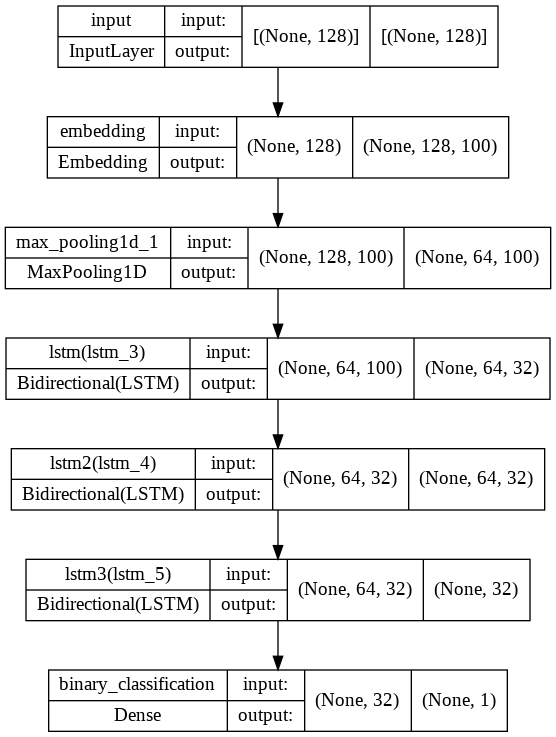

In [103]:
plot_model(model_builder(HyperParameters()), show_shapes=True)

In [104]:
# search
tuner = Hyperband(hypermodel=model_builder,
                  objective='val_accuracy',
                  max_epochs=10)
tuner.search(x_train,
             y_train,
             epochs=10,
             validation_data=(x_val, y_val),
             callbacks=[stop_early],
             batch_size=64)

Trial 30 Complete [00h 08m 12s]
val_accuracy: 0.561961829662323

Best val_accuracy So Far: 0.858854353427887
Total elapsed time: 01h 41m 22s
INFO:tensorflow:Oracle triggered exit


In [107]:
best_hps = tuner.get_best_hyperparameters()[0]
# train model after tunning
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    validation_data=(x_val, y_val),
                    batch_size=64,
                    callbacks=[stop_early, save_best_model])

Epoch 1/20
251/251 [==============================] - 54s 171ms/step - loss: 0.4085 - accuracy: 0.7990 - val_loss: 0.3386 - val_accuracy: 0.8461
Epoch 2/20
251/251 [==============================] - 40s 160ms/step - loss: 0.1371 - accuracy: 0.9498 - val_loss: 0.4030 - val_accuracy: 0.8446
Epoch 3/20
251/251 [==============================] - 40s 160ms/step - loss: 0.0449 - accuracy: 0.9845 - val_loss: 0.5215 - val_accuracy: 0.8392
Epoch 4/20
251/251 [==============================] - 40s 159ms/step - loss: 0.0168 - accuracy: 0.9946 - val_loss: 0.7265 - val_accuracy: 0.8355


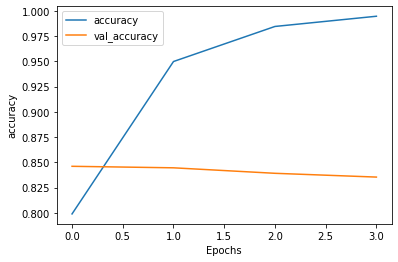

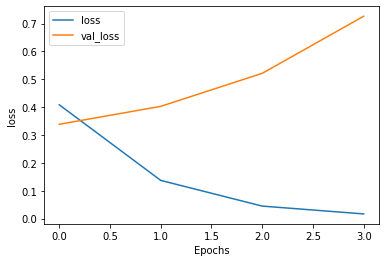

In [108]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_' + string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_' + string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Evaluate

In [109]:
# load best model's weights
saved_model = load_model('checkpoints/rnn')
loss, acc = saved_model.evaluate(x_test, y_test, batch_size=64, verbose=0)
print(f'Loss is: {loss} \nAcc is: {acc} \n')

# f1 score
y_pred = (model.predict(x_test) > 0.5).astype('int32')
print(classification_report(y_test, y_pred))

Loss is: 0.3232583999633789 
Acc is: 0.8577311635017395 

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      3014
           1       0.85      0.78      0.81      2328

    accuracy                           0.84      5342
   macro avg       0.84      0.84      0.84      5342
weighted avg       0.84      0.84      0.84      5342



In [110]:
# predict
sentences = ["It’s okay if you don’t like me. Not everyone has good taste.",
             "Today is a nice day."]
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, padding='post', truncating='post', maxlen=MAXLEN)
model.predict(padded)

array([[0.9989574 ],
       [0.00274033]], dtype=float32)